In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')

#device = torch.device("mps")
device = torch.device("cpu")
print(device, torch.__version__)
#torch.manual_seed(1802)

mat = loadmat("../data/fan_flutter.mat")["x"]
x_sample = torch.from_numpy(mat).float()[:, 4_000:10_000]

reg = 0.01

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

def time_function(f, device, time_list=None):
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    start = time.time()
    result = f()
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    end = time.time()
    elapsed = end-start
    if time_list is None:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    else:
        time_list.append(elapsed)
    return result


cpu 2.7.0


Here, the fastDSTFT is tested

Using CPU


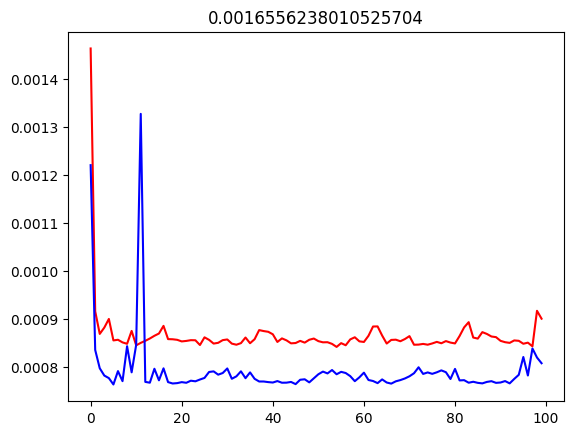

MEANS
Mean time per step:
coefficients         0.002654
final computation    0.018764
modulation           0.002016
spline_stft          0.026862
dtype: float64

Total mean time per run: 0.050296 seconds

Percentage of total mean time per step:
coefficients          5.276759
final computation    37.307869
modulation            4.007389
spline_stft          53.407984
dtype: float64

MEDIANS
Median time per step:
coefficients         0.002559
final computation    0.018466
modulation           0.001976
spline_stft          0.026818
dtype: float64

Total median time per run: 0.049819 seconds

Percentage of total median time per step:
coefficients          5.136463
final computation    37.065999
modulation            3.966845
spline_stft          53.830692
dtype: float64


In [3]:
from dstft import fastDSTFT, ADSTFT2
from dstft import reset_timing, analyze_csv_timings
reset_timing()
batch_size = 64
x = x_sample.repeat(batch_size, 1).to(device)
dstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',
                    spline_degree = 3,
                    padding = "valid"
                    )
"""dstft = ADSTFT2(x,  # actual_win_length=win_length and there is a put_windows_back() method
                win_length=577, 
                support=1_000, 
                stride=50, 
                win_requires_grad=True, 
                stride_requires_grad=False, 
                win_p='tf', 
                win_min=100
                )"""
#dstft = torch.compile(dstft, mode="default")  # no difference on cpu, crash on mps
mini_loss = lambda x: x.sum() * 0 +1  # lambda x: x.view(-1)[0] * 0 + 1  
with torch.no_grad():
    spec, *_ = dstft(x)  # making one calculation to avoid initialization overhead
initial_lr = 100.0  # 0.01, 10.0, 100.0
params = [{'params': dstft.parameters(),'lr': initial_lr}] 
opt = torch.optim.Adam(params)

if device.type=="mps":
    print("Using MPS")
else:
    print("Using CPU")
err = mini_loss(spec)

fwtimes = []
bwtimes = []
for epoch in range(100):
    #opt.zero_grad()
    for param in dstft.parameters():
        param.grad = None
    spec, *_ = time_function(lambda: dstft(x), device, fwtimes)
    err = mini_loss(spec)
    time_function(lambda: err.backward(), device, bwtimes)
    opt.step()
    dstft.put_windows_back()
fwtimes = np.array(fwtimes)
bwtimes = np.array(bwtimes)
plt.plot(fwtimes/batch_size, 'r')
plt.plot(bwtimes/batch_size, 'b')
plt.title((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
plt.show()

analyze_csv_timings()


Timing values. Average over 100 epochs with mini_loss, best of 3 runs.

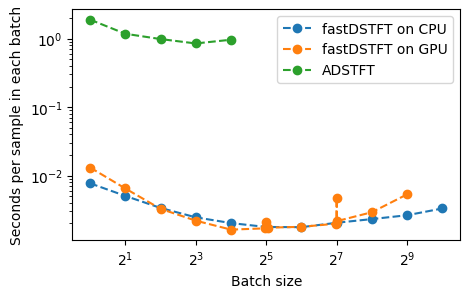

In [11]:
fastDSTFT_cpu_times = {
  1: 0.00770,
  2: 0.00504,
  4: 0.00336,
  8: 0.00245,
  16: 0.00202,
  32: 0.00177,
  64: 0.00176,
  128: 0.00204,
  256: 0.00231,
  512: 0.00263,
  1024: 0.00330
}

fastDSTFT_gpu_times = {
  1: 0.0131,
  2: 0.00647,
  4: 0.00326,
  8: 0.00219,
  16: 0.00162,
  31: 0.00169,
  32: 0.00211,
  33: 0.00173,
  64: 0.00178,
  127: 0.00198,
  128: 0.00469,
  129: 0.00216,
  256: 0.00291,
  512: 0.00531
}

ADSTFT_times = {
  1: 1.90,
  2: 1.18,
  4: 0.988,
  8: 0.852,
  16: 0.966,
}

fig = plt.figure(figsize=(5, 3))
plt.plot(fastDSTFT_cpu_times.keys(), fastDSTFT_cpu_times.values(), '--o', label="fastDSTFT on CPU")
plt.plot(fastDSTFT_gpu_times.keys(), fastDSTFT_gpu_times.values(), '--o', label="fastDSTFT on GPU")
plt.plot(ADSTFT_times.keys(), ADSTFT_times.values(), '--o', label="ADSTFT")
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Batch size')
plt.ylabel('Seconds per sample in each batch')
plt.legend()


Investigating how wide the splines are

heyy 4.999999523162842
tensor(81.5714)
81.57145146519832


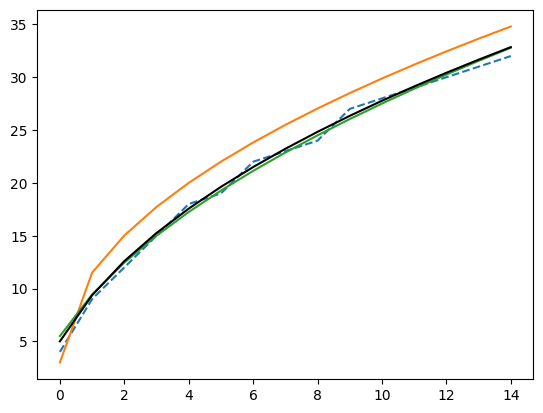

In [74]:
def find_region(x, p):
    cdf = torch.cumsum(p, dim=0)
    tail = (1-0.9973)/2
    left_idx = torch.searchsorted(cdf, tail)
    right_idx = torch.searchsorted(cdf, 1-tail)
    left_value = x[left_idx]
    right_value = x[right_idx]
    return left_value, right_value
stds = []
mads = []
widths = []
max = 15
stride = 10
for degree in range(max):
    fastdstft = fastDSTFT(n_fft=1_000, 
                        stride=stride,
                        initial_win_length=577,
                        window_function='beta',  # 'hann, 'beta'
                        spline_degree = degree,
                        padding = "same"
                        )
    bspline_basis = fastdstft._generate_bspline()
    #print(bspline_basis)
    p = bspline_basis/bspline_basis.sum()
    t = torch.arange(p.shape[0])
    left, right = find_region(t, p)
    if degree==-1:#3:
        plt.plot(p)
        #plt.plot(t, 0.001*torch.ones(p.shape[0]))
        plt.plot([left, right], [0, 0])
        plt.show()
    x = torch.arange(p.shape[0])
    mean = torch.sum(p * x)
    widths.append(right-left)
plt.plot(range(max), torch.tensor(widths), '--')
#plt.plot(range(max), -15+60*torch.tensor(range(max))**(1/3))
#plt.plot(range(max), -2+48.5*torch.tensor(range(max))**(1/2))
#plt.plot(range(max), -2+1.93*stride/2*torch.tensor(range(max))**(1/2))
plt.plot(range(max), 3+1.7*stride/2*torch.tensor(range(max))**(1/2))
plt.plot(range(max), -4/5*(stride/2)+1.9*stride/2*(1+torch.tensor(range(max)))**(1/2))

# this one is good:
a = 1.24
plt.plot(range(max), (1-2*a)*stride/2 + 2*a*stride/2*(1+torch.tensor(range(max)))**(1/2.3), 'k')

print(f"heyy {(1-2*a)*stride/2 + 2*a*stride/2*(1+torch.tensor(0))**(1/2.3)}")

# -2 +1.93*self.spline_stride*torch.sqrt(self.spline_degree)
print(-2 +1.93*25*torch.sqrt(torch.tensor(3)))
print(-2 +1.93*25*3**(1/2))
plt.show()

Fixing the spline alignment

0.9999993
tensor(1.0000)


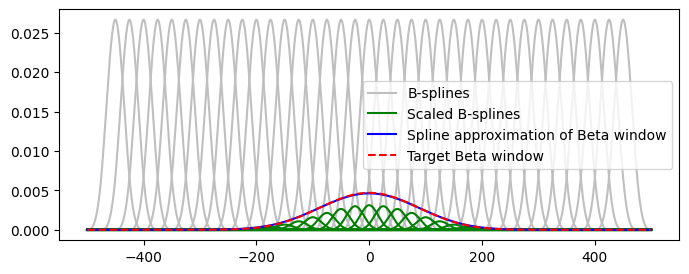

tensor(0.0063)


/var/folders/2b/nl23g7s157981ybyrxb6mhdm0000gn/T/ipykernel_17514/766951771.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[2].plot(t, x_part*target, 'r--', label="Target Beta windowed x")


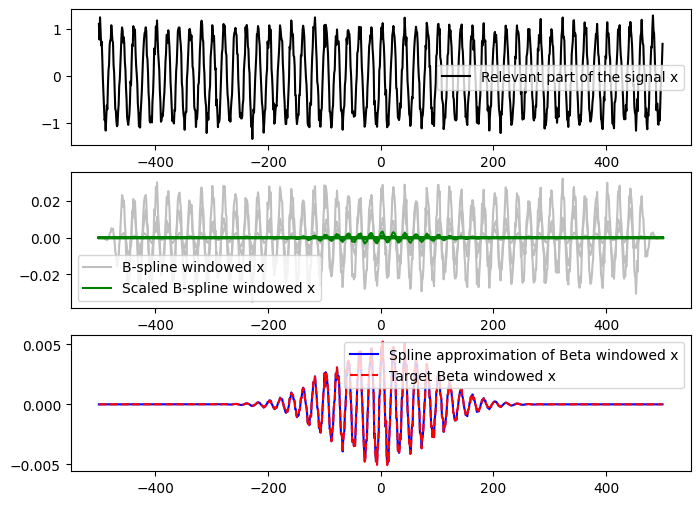

/var/folders/2b/nl23g7s157981ybyrxb6mhdm0000gn/T/ipykernel_17514/766951771.py:94: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fft = torch.fft.rfft(x_part*target)


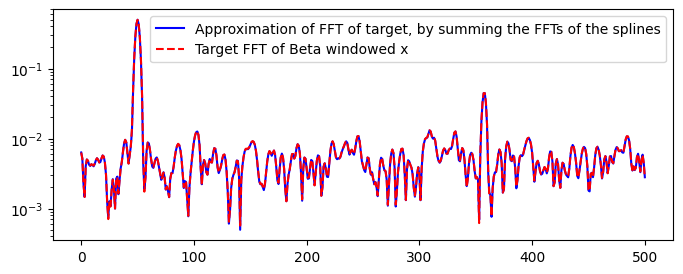

In [55]:
fastdstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=500,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree = 3,
                    padding = "same"
                    )
fastdstft(x)
s = fastdstft.s
coefficients_ = fastdstft._coefficients(fastdstft.window_lengths).detach().numpy()
coefficients = coefficients_[100, :, 100]
print(coefficients.sum())
bspline = fastdstft._generate_bspline()
length = len(bspline)

# windows
fig = plt.figure(figsize=(8, 3))
base = torch.zeros(1000)
spline_stride = fastdstft.spline_stride
sum = base.clone()
t = np.linspace(-(s//2*spline_stride+length/2), s//2*spline_stride+length/2, (s-1)*spline_stride+length)
for i in range(0, s):
    spline = base.clone()
    spline[i*spline_stride:i*spline_stride+length] = bspline
    if i==0:
        plt.plot(t, spline, color=(0.75, 0.75, 0.75), zorder=0, label="B-splines")
        plt.plot(t, spline*coefficients[i], zorder=1, label="Scaled B-splines", color="green")#(0.6, 0.75, 0.85))
    else:
        plt.plot(t, spline, zorder=0, color=(0.75, 0.75, 0.75))
        plt.plot(t, spline*coefficients[i], zorder=1, color="green")#(0.6, 0.75, 0.85))
    sum += spline*coefficients[i]
print(sum.sum())
plt.plot(t, sum, color='blue', label="Spline approximation of Beta window")
from scipy.stats import beta
width = fastdstft.window_lengths.detach()[100, 100]
a = 1/2* ( (3000/width)**2 -1 )
b = a
target_ = beta.pdf(t/1000+0.5, a, b)
target = target_/target_.sum()
plt.plot(t, target, 'r--', label="Target Beta window")
plt.legend()
plt.show()

# windowed x
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
x_part = x_sample[0, 0:1000]
base = torch.zeros(1000)
sum = base.clone()
axs[0].plot(t, x_part, color="black", zorder=0, label="Relevant part of the signal x")
for i in range(0, s):
    spline = base.clone()
    spline[i*spline_stride:i*spline_stride+length] = bspline
    bspline_windowed_x = x_part*spline
    if i==0:
        axs[1].plot(t, bspline_windowed_x, color=(0.75, 0.75, 0.75), zorder=1, label="B-spline windowed x")
        axs[1].plot(t, bspline_windowed_x*coefficients[i], zorder=2, label="Scaled B-spline windowed x", color="green")#(0.6, 0.75, 0.85))
    else:
        axs[1].plot(t, bspline_windowed_x, zorder=1, color=(0.75, 0.75, 0.75))
        axs[1].plot(t, bspline_windowed_x*coefficients[i], zorder=2, color="green")#(0.6, 0.75, 0.85))
    sum += bspline_windowed_x*coefficients[i]
print(sum.sum())
axs[2].plot(t, sum, color='blue', label="Spline approximation of Beta windowed x")
from scipy.stats import beta
width = fastdstft.window_lengths.detach()[100, 100]
a = 1/2* ( (3000/width)**2 -1 )
b = a
target_ = beta.pdf(t/1000+0.5, a, b)
target = target_/target_.sum()
axs[2].plot(t, x_part*target, 'r--', label="Target Beta windowed x")
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

# fourier transform of windowed x
fig = plt.figure(figsize=(8, 3))
fs = np.linspace(0, 500, 501)
x_part = x_sample[0, 0:1000]
base = torch.zeros(1000)
sum = torch.zeros(501, dtype=torch.complex64)
for i in range(0, s):
    spline = base.clone()
    spline[i*spline_stride:i*spline_stride+length] = bspline
    bspline_windowed_x = x_part*spline
    fft = torch.fft.rfft(bspline_windowed_x*coefficients[i])
    sum += fft
plt.plot(fs, sum.abs(), color="blue", label="Approximation of FFT of target, by summing the FFTs of the splines")
from scipy.stats import beta
width = fastdstft.window_lengths.detach()[100, 100]
a = 1/2* ( (3000/width)**2 -1 )
b = a
target_ = beta.pdf(t/1000+0.5, a, b)
target = target_/target_.sum()
fft = torch.fft.rfft(x_part*target)
plt.plot(fs, fft.abs(), 'r--', label="Target FFT of Beta windowed x")
plt.yscale("log")
plt.legend()
plt.show()

# spectrogram (how do i do this?)


1.0
tensor(1.0000)


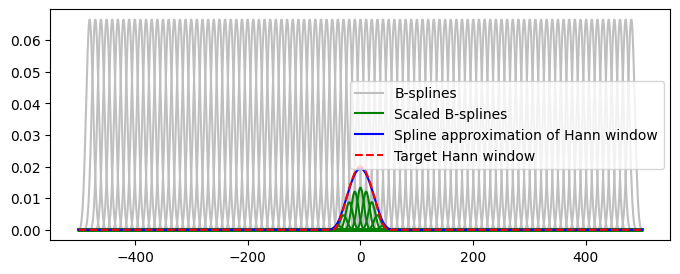

In [60]:
fastdstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=100,
                    window_function='hann',  # 'hann, 'beta'
                    spline_degree = 3,
                    spline_density=5,
                    padding = "same"
                    )
fastdstft(x)
s = fastdstft.s
coefficients_ = fastdstft._coefficients(fastdstft.window_lengths).detach().numpy()
coefficients = coefficients_[100, :, 100]
print(coefficients.sum())
bspline = fastdstft._generate_bspline()
length = len(bspline)

# windows
fig = plt.figure(figsize=(8, 3))
base = torch.zeros(1000)
spline_stride = fastdstft.spline_stride
sum = base.clone()
t = np.linspace(-(s//2*spline_stride+length/2), s//2*spline_stride+length/2, (s-1)*spline_stride+length)
for i in range(0, s):
    spline = base.clone()
    spline[i*spline_stride:i*spline_stride+length] = bspline
    if i==0:
        plt.plot(t, spline, color=(0.75, 0.75, 0.75), zorder=0, label="B-splines")
        plt.plot(t, spline*coefficients[i], zorder=1, label="Scaled B-splines", color="green")#(0.6, 0.75, 0.85))
    else:
        plt.plot(t, spline, zorder=0, color=(0.75, 0.75, 0.75))
        plt.plot(t, spline*coefficients[i], zorder=1, color="green")#(0.6, 0.75, 0.85))
    sum += spline*coefficients[i]
print(sum.sum())
plt.plot(t, sum, color='blue', label="Spline approximation of Hann window")
from scipy.stats import beta
width = fastdstft.window_lengths.detach()[100, 100].numpy()
half_width = width/2
target_ = 0.5 * (1 + np.cos(np.pi * (t) / half_width))
target_[np.abs(t) > half_width] = 0
target_ = torch.tensor(target_)
target = target_/target_.sum()
plt.plot(t, target, 'r--', label="Target Hann window")
plt.legend()
plt.show()

Here, the paper ADSTFT is tested

In [ ]:
adstftdevice = "cpu"  # does not work on gpu
batch_size = 1

from dstft import ADSTFT
x = x_sample.repeat(batch_size, 1).to(adstftdevice)
dstft = ADSTFT(x_sample, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(adstftdevice)

spec, *_ = dstft(x)

fwtimes = []
bwtimes = []

initial_lr = 100.0  # 0.01, 10.0, 100.0
params = [{'params': dstft.parameters(),'lr': initial_lr}] 
errs = []
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19)
lr_decrease = []
lr = opt.param_groups[0]['lr']

for epoch in range(1_000):
    for param in dstft.parameters():
        param.grad = None

    tic()
    spec, *_ = dstft(x)
    fwtimes.append(toc(print_elapsed=False))

    err = entropy_loss(spec) + reg* (dstft.win_length.diff(dim=0)[:, :-1].pow(2) + dstft.win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())

    tic()
    err.backward()
    bwtimes.append(toc(print_elapsed=False))

    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < 1:
            break
print(np.mean(fwtimes)/batch_size)
print(np.mean(bwtimes)/batch_size)
print((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
# handles batches of up to 8 at 2.4 per sample, fastest at 4 with 1.1

print(lr_decrease)
plt.plot(errs)
plt.plot(lr_decrease, [errs[i] for i in lr_decrease], 'ro')
plt.show()


KeyboardInterrupt: 

In [118]:
from dstft import fastDSTFT, ADSTFT2
batch_size = 1
x = x_sample.repeat(batch_size, 1)
initial_lr = 100.0

fastdstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree=3,
                    spline_density=5,
                    win_min = 100,
                    padding = "valid"  # "same"
                    )
spec = fastdstft(x)
params = [{'params': fastdstft.parameters(),'lr': initial_lr}] 
opt_fast = torch.optim.Adam(params)
errs_fast = []
err_fast = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs_fast.append(err_fast.item())

dstft = ADSTFT2(x,  # actual_win_length=win_length and there is a put_windows_back() method
                win_length=577, 
                support=1_000, 
                stride=50, 
                win_requires_grad=True, 
                stride_requires_grad=False, 
                win_p='tf', 
                win_min=100)
spec, *_ = dstft(x)
params = [{'params': dstft.parameters(),'lr': initial_lr}] 
opt = torch.optim.Adam(params)
errs = []
err = entropy_loss(spec) + reg* (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs.append(err.item())

lr_decrease = [200, 200+200, 200+200+200]
for epoch in range(1_000):
    if epoch in lr_decrease:
        lr = opt_fast.param_groups[0]['lr']/10
        opt_fast.param_groups[0]['lr'] = lr
        opt.param_groups[0]['lr'] = lr
        if lr < initial_lr/100:
            break

    opt_fast.zero_grad()
    spec = fastdstft(x)
    err_fast = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs_fast.append(err_fast.item())
    err_fast.backward()
    opt_fast.step()
    fastdstft.put_windows_back()
    
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + reg* (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())
    err.backward()
    opt.step()
    dstft.put_windows_back()

In [ ]:
fastdstft_shorter = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree = 3,
                    spline_density=2,  # 5
                    win_min = 60,  # 93
                    padding = "valid"  # "same"
                    )
spec = fastdstft_shorter(x)
params = [{'params': fastdstft_shorter.parameters(),'lr': initial_lr}] 
opt = torch.optim.Adam(params)
errs_shorter = []
err = entropy_loss(spec) + reg* (fastdstft_shorter.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft_shorter.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs_shorter.append(err.item())

lr_decrease = [200, 200+200, 200+200+200]
for epoch in range(1_000):
    if epoch in lr_decrease:
        lr = opt.param_groups[0]['lr']/10
        opt.param_groups[0]['lr'] = lr
        opt.param_groups[0]['lr'] = lr
        if lr < initial_lr/100:
            break

    opt.zero_grad()
    spec = fastdstft_shorter(x)
    err = entropy_loss(spec) + reg* (fastdstft_shorter.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft_shorter.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs_shorter.append(err.item())
    err.backward()
    opt.step()
    fastdstft_shorter.put_windows_back()

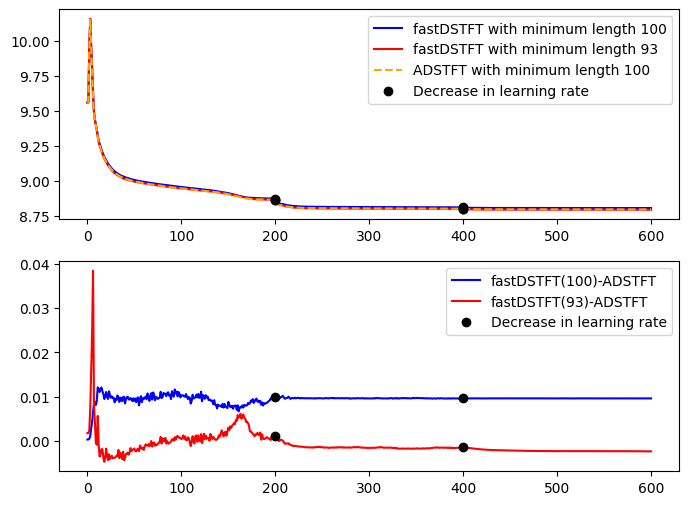

In [173]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
torch_errs_fast = torch.tensor(errs_fast)
torch_errs_shorter = torch.tensor(errs_shorter)
torch_errs = torch.tensor(errs)
minmin = min(torch_errs.min(), torch_errs_fast.min())
based_errs_fast = torch.tensor(errs_fast)
based_errs_shorter = torch.tensor(errs_shorter)
based_errs = torch.tensor(errs)
axs[0].plot(based_errs_fast, 'b', label="fastDSTFT with minimum length 100")
axs[0].plot(based_errs_shorter, 'r', label="fastDSTFT with minimum length 93")
axs[0].plot(based_errs, '--', color='orange', label="ADSTFT with minimum length 100")
axs[0].plot(lr_decrease[:-1], [based_errs_fast[i] for i in lr_decrease[:-1]], 'ko', label="Decrease in learning rate")
axs[0].plot(lr_decrease[:-1], [based_errs_shorter[i] for i in lr_decrease[:-1]], 'ko')
axs[0].plot(lr_decrease[:-1], [based_errs[i] for i in lr_decrease[:-1]], 'ko')
axs[0].legend()

diff = torch_errs_fast -torch_errs
diff_shorter = torch_errs_shorter -torch_errs
axs[1].plot(diff, 'b', label="fastDSTFT(100)-ADSTFT")
axs[1].plot(lr_decrease[:-1], [diff[i] for i in lr_decrease[:-1]], 'ko')
axs[1].plot(diff_shorter, 'r', label="fastDSTFT(93)-ADSTFT")
axs[1].plot(lr_decrease[:-1], [diff_shorter[i] for i in lr_decrease[:-1]], 'ko', label="Decrease in learning rate")
axs[1].legend()

tensor(-0.3487, grad_fn=<MinBackward1>) tensor(-3.0352e-06, grad_fn=<MedianBackward0>) tensor(0.3498, grad_fn=<MaxBackward1>)


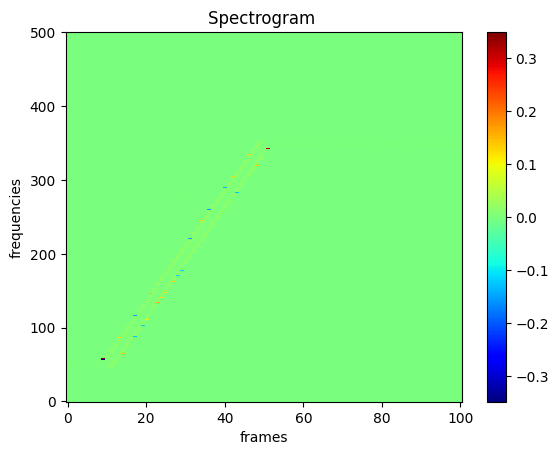

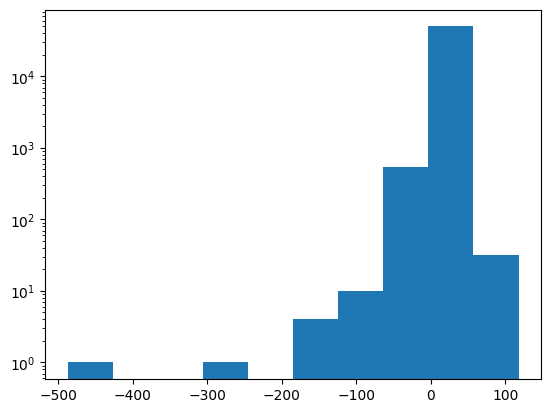

In [174]:
spec_fast = fastdstft_shorter(x)#fastdstft, fastdstft_shorter
#fastdstft.plot(spec_fast)

spec, *_ = dstft(x)
#dstft.plot(spec, wins=False, bar=True)

diff = (spec_fast-spec)#/spec_fast
print(diff.min(), diff.median(), diff.max())
fastdstft.plot(diff, log=False, weights=False)
#plt.hist(diff.detach().flatten())
#plt.yscale('log')
#plt.show()

diff_length = fastdstft.window_lengths.detach()-dstft.win_length.detach()
#print(diff_length.min(), diff_length.median(), diff_length.max())
#fastdstft.plot(diff_length.unsqueeze(0), log=False, weights=False)
plt.hist(diff_length.detach().flatten())
plt.yscale('log')
plt.show()